# **CAPSTONE PROJECT 2 TEMPLATE**
### [Your Project Title Here]

**Student Name:** [Your Name]  
**Date:** [Date]  
**Course:** Intermediate AI & Data Science  
**Instructor:** Amir Charkhi  
**AI Tech Institute**

---

## 📋 Project Overview

**Problem:** [One sentence describing what you're predicting/forecasting]

**Business Value:** [Why this matters - 1-2 sentences]

**Data Source:** [Where you got the data]

**Target Variable:** [What you're predicting]

**Success Metric:** [How you'll measure success]

---

## 1. Setup & Imports

In [108]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [109]:
# Plotly for interactive visualizations
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [110]:
# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

# Add your specific model imports here
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# etc.

In [111]:
# Metrics (adjust based on your problem type)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,  # Classification
    mean_squared_error, mean_absolute_error, r2_score,        # Regression
    classification_report, confusion_matrix                    # Detailed reports
)

In [112]:
# Model persistence
import joblib

---
## 2. Load Data

In [113]:
trans_train = pd.read_csv('train_transaction.csv')
tran_test = pd.read_csv('test_transaction.csv')
identity_train = pd.read_csv('train_identity.csv')
identity_test = pd.read_csv('test_identity.csv')

### Data Optimization

 The dataset contains approximately 594,000 rows and more than 400 columns, which can exceed the storage and memory capacity of a local machine. To improve efficiency and reduce resource usage, a function was applied to adjust the data types of all columns, ensuring optimal memory utilization without compromising data integrity (This function was taken from a Kaggle notebook.).



In [114]:
# Helper function
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [115]:
trans_train_reduced = reduce_mem_usage(trans_train) 
tran_test_reduced = reduce_mem_usage(tran_test)

Memory usage of dataframe is 1775.15 MB
Memory usage after optimization is: 487.16 MB
Decreased by 72.6%
Memory usage of dataframe is 1519.24 MB
Memory usage after optimization is: 425.24 MB
Decreased by 72.0%


In [116]:
## Merging transaction and identity data

trans_train_merged = pd.merge(trans_train_reduced, identity_train, on='TransactionID', how='left')

test_trans_merged = pd.merge(tran_test_reduced, identity_test, on='TransactionID', how='left')



In [117]:
# Dataset shape
print(f"Train Dataset: {trans_train_merged.shape[0]} rows × {trans_train_merged.shape[1]} columns.\n")
    
print(trans_train_merged.head(10))

print(f"Test Dataset: {test_trans_merged.shape[0]} rows × {test_trans_merged.shape[1]} columns.\n")

print(test_trans_merged.head(10))

Train Dataset: 590540 rows × 434 columns.

   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   
5        2987005        0          86510            49.0         W   5937   
6        2987006        0          86522           159.0         W  12308   
7        2987007        0          86529           422.5         W  12695   
8        2987008        0          86535            15.0         H   2803   
9        2987009        0          86536           117.0         W  17399   

   card2  card3       card4  card5  ...                id_31  id_32  \
0    NaN  150.0    discover  142.0  ..

---
## 3. Exploratory Data Analysis (EDA)

### 3.1 Basic Statistics

In [203]:
# Dataset info
trans_train_merged.iloc[:, :15].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   TransactionID   590540 non-null  int32   
 1   isFraud         590540 non-null  int8    
 2   TransactionDT   590540 non-null  int32   
 3   TransactionAmt  590540 non-null  float16 
 4   ProductCD       590540 non-null  category
 5   card1           590540 non-null  int16   
 6   card2           581607 non-null  float16 
 7   card3           588975 non-null  float16 
 8   card4           588963 non-null  category
 9   card5           586281 non-null  float16 
 10  card6           588969 non-null  category
 11  addr1           524834 non-null  float16 
 12  addr2           524834 non-null  float16 
 13  dist1           238269 non-null  float16 
 14  dist2           37627 non-null   float16 
dtypes: category(3), float16(8), int16(1), int32(2), int8(1)
memory usage: 16.9 MB


In [199]:
trans_train_merged.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.0,588975.0,586281.0,524834.0,524834.0,...,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.000000
mean,3.282270e+06,0.034990,7.372311e+06,NaN,9898.734658,NaN,NaN,NaN,NaN,NaN,...,189.451377,14.237337,353.128174,403.882666,368.269820,16.002708,12.800927,329.608924,149.070308,26.508597
std,1.704744e+05,0.183755,4.617224e+06,NaN,4901.170153,NaN,0.0,0.0,NaN,0.0,...,30.375360,1.561302,141.095343,152.160327,198.847038,6.897665,2.372447,97.461089,32.101995,3.737502
min,2.987000e+06,0.000000,8.640000e+04,0.250977,1000.000000,100.0,100.0,100.0,100.0,10.0,...,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.312500,6019.000000,214.0,150.0,166.0,204.0,87.0,...,166.000000,13.000000,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,119.000000,24.000000
50%,3.282270e+06,0.000000,7.306528e+06,68.750000,9678.000000,361.0,150.0,226.0,299.0,87.0,...,166.000000,15.000000,341.000000,472.000000,252.000000,14.000000,11.000000,321.000000,149.000000,24.000000
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.0,150.0,226.0,330.0,87.0,...,225.000000,15.000000,427.000000,533.000000,486.500000,14.000000,15.000000,371.000000,169.000000,32.000000
max,3.577539e+06,1.000000,1.581113e+07,31936.000000,18396.000000,600.0,231.0,237.0,540.0,102.0,...,229.000000,29.000000,671.000000,661.000000,854.000000,44.000000,26.000000,548.000000,216.000000,32.000000


In [119]:
# Check missing values
missing = trans_train_merged.isnull().mean()
missing =  missing[missing > 0].reset_index()
missing.rename(columns={0: 'missing_percentage'}, inplace=True)
missing.sort_values(by='missing_percentage', ascending=False).head(20)



,index,missing_percentage
397,id_24,0.991962
398,id_25,0.991310
380,id_07,0.991271
381,id_08,0.991271
394,id_21,0.991264
399,id_26,0.991257
400,id_27,0.991247
396,id_23,0.991247
395,id_22,0.991247
8,dist2,0.936284


Drop columns have missing rate above 90% to reduce noisy

In [155]:
missing_rate_threshold = 0.9
cols_to_drop = missing[missing['missing_percentage'] > missing_rate_threshold]['index'].tolist()
# drop only those columns that exist in the dataframe to avoid KeyError
trans_train_clean = trans_train_merged.loc[:, trans_train_merged.isnull().mean() < 0.9]

print("Columns dropped due to high missing rate:")
for col in cols_to_drop:
    print(col)

trans_train_clean.head()



Columns dropped due to high missing rate:
dist2
D7
id_07
id_08
id_18
id_21
id_22
id_23
id_24
id_25
id_26
id_27


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


---
## 3. Exploratory Data Analysis (EDA)

### 3.1 Basic Statistics

In [160]:
trans_train_clean['isFraud'].value_counts()

isFraud
0    569877
1     20663
Name: count, dtype: int64

### 3.2 Target Variable Analysis

In [157]:
trans_train_clean.iloc[:, :15]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain
0,2987000,0,86400,68.500000,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN
1,2987001,0,86401,29.000000,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,gmail.com
2,2987002,0,86469,59.000000,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,outlook.com
3,2987003,0,86499,50.000000,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,yahoo.com
4,2987004,0,86506,50.000000,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,gmail.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.000000,W,6550,NaN,150.0,visa,226.0,debit,272.0,87.0,48.0,NaN
590536,3577536,0,15811049,39.500000,W,10444,225.0,150.0,mastercard,224.0,debit,204.0,87.0,NaN,gmail.com
590537,3577537,0,15811079,30.953125,W,12037,595.0,150.0,mastercard,224.0,debit,231.0,87.0,NaN,gmail.com
590538,3577538,0,15811088,117.000000,W,7826,481.0,150.0,mastercard,224.0,debit,387.0,87.0,3.0,aol.com


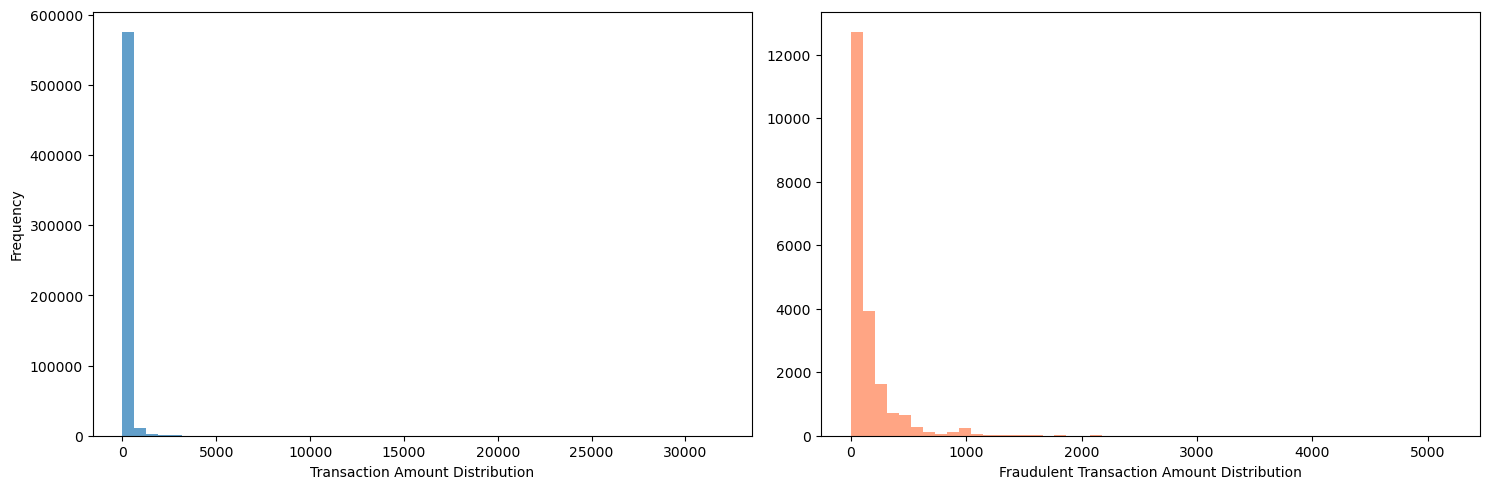


Transaction Amount Statistics Comparison
                      Model       Mean  Median  Standard Deviation
           All Transactions 135.027347   68.75          239.157438
    Fraudulent Transactions 149.244353   75.00          232.208745
Non-Fraudulent Transactions 134.511857   68.50          239.389936


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

ax1 =axes[0]
ax1.hist(trans_train_clean['TransactionAmt'], bins=50, alpha=0.7)
ax1.set_xlabel('Transaction Amount Distribution')
ax1.set_ylabel('Frequency')

ax2 =axes[1]
ax2.hist(trans_train_clean[trans_train_clean['isFraud']==1]['TransactionAmt'], bins=50,color='coral', alpha=0.7)
ax2.set_xlabel('Fraudulent Transaction Amount Distribution')


plt.tight_layout()
plt.show()


fraud_amt = trans_train_clean[trans_train_clean['isFraud']==1]['TransactionAmt'].astype(float)
non_fraud_amt = trans_train_clean[trans_train_clean['isFraud']==0]['TransactionAmt'].astype(float)
total_amt = trans_train_clean['TransactionAmt'].astype(float)

# Create comparison table
comparison_df = pd.DataFrame({
    'Type': [
        'All Transactions',
        'Fraudulent Transactions',
        'Non-Fraudulent Transactions'
     
    ],
    'Mean': [
        total_amt.mean(),
        fraud_amt.mean(),
        non_fraud_amt.mean()
    ],
    'Median': [
        total_amt.median(),
        fraud_amt.median(),
        non_fraud_amt.median()
    ],
    'Standard Deviation': [
        total_amt.std(),
        fraud_amt.std(),    
        non_fraud_amt.std()
    ]
})



print("\n" + "="*90)
print("Transaction Amount Statistics Comparison")
print("="*90)
print(comparison_df.to_string(index=False))




In [ ]:
#Define transaction amount outliers using IQR method

Q1 = total_amt.quantile(0.25)
Q3 = total_amt.quantile(0.75)
IQR = Q3 - Q1

outliers = total_amt[(total_amt < (Q1 - 1.5 * IQR)) | (total_amt > (Q3 + 1.5 * IQR))]

print(total_amt.sort_values(ascending=False).head(10))
print("="*90)
print(total_amt.sort_values(ascending=True).head(10))





274336    31936.0
274339    31936.0
296021     6452.0
248413     6084.0
384603     5544.0
275529     5420.0
275535     5420.0
584767     5368.0
315172     5280.0
462514     5280.0
Name: TransactionAmt, dtype: float64
374299    0.250977
367961    0.271973
205370    0.291992
205865    0.291992
205872    0.291992
29976     0.291992
205382    0.291992
205393    0.350098
492354    0.364014
42265     0.424072
Name: TransactionAmt, dtype: float64


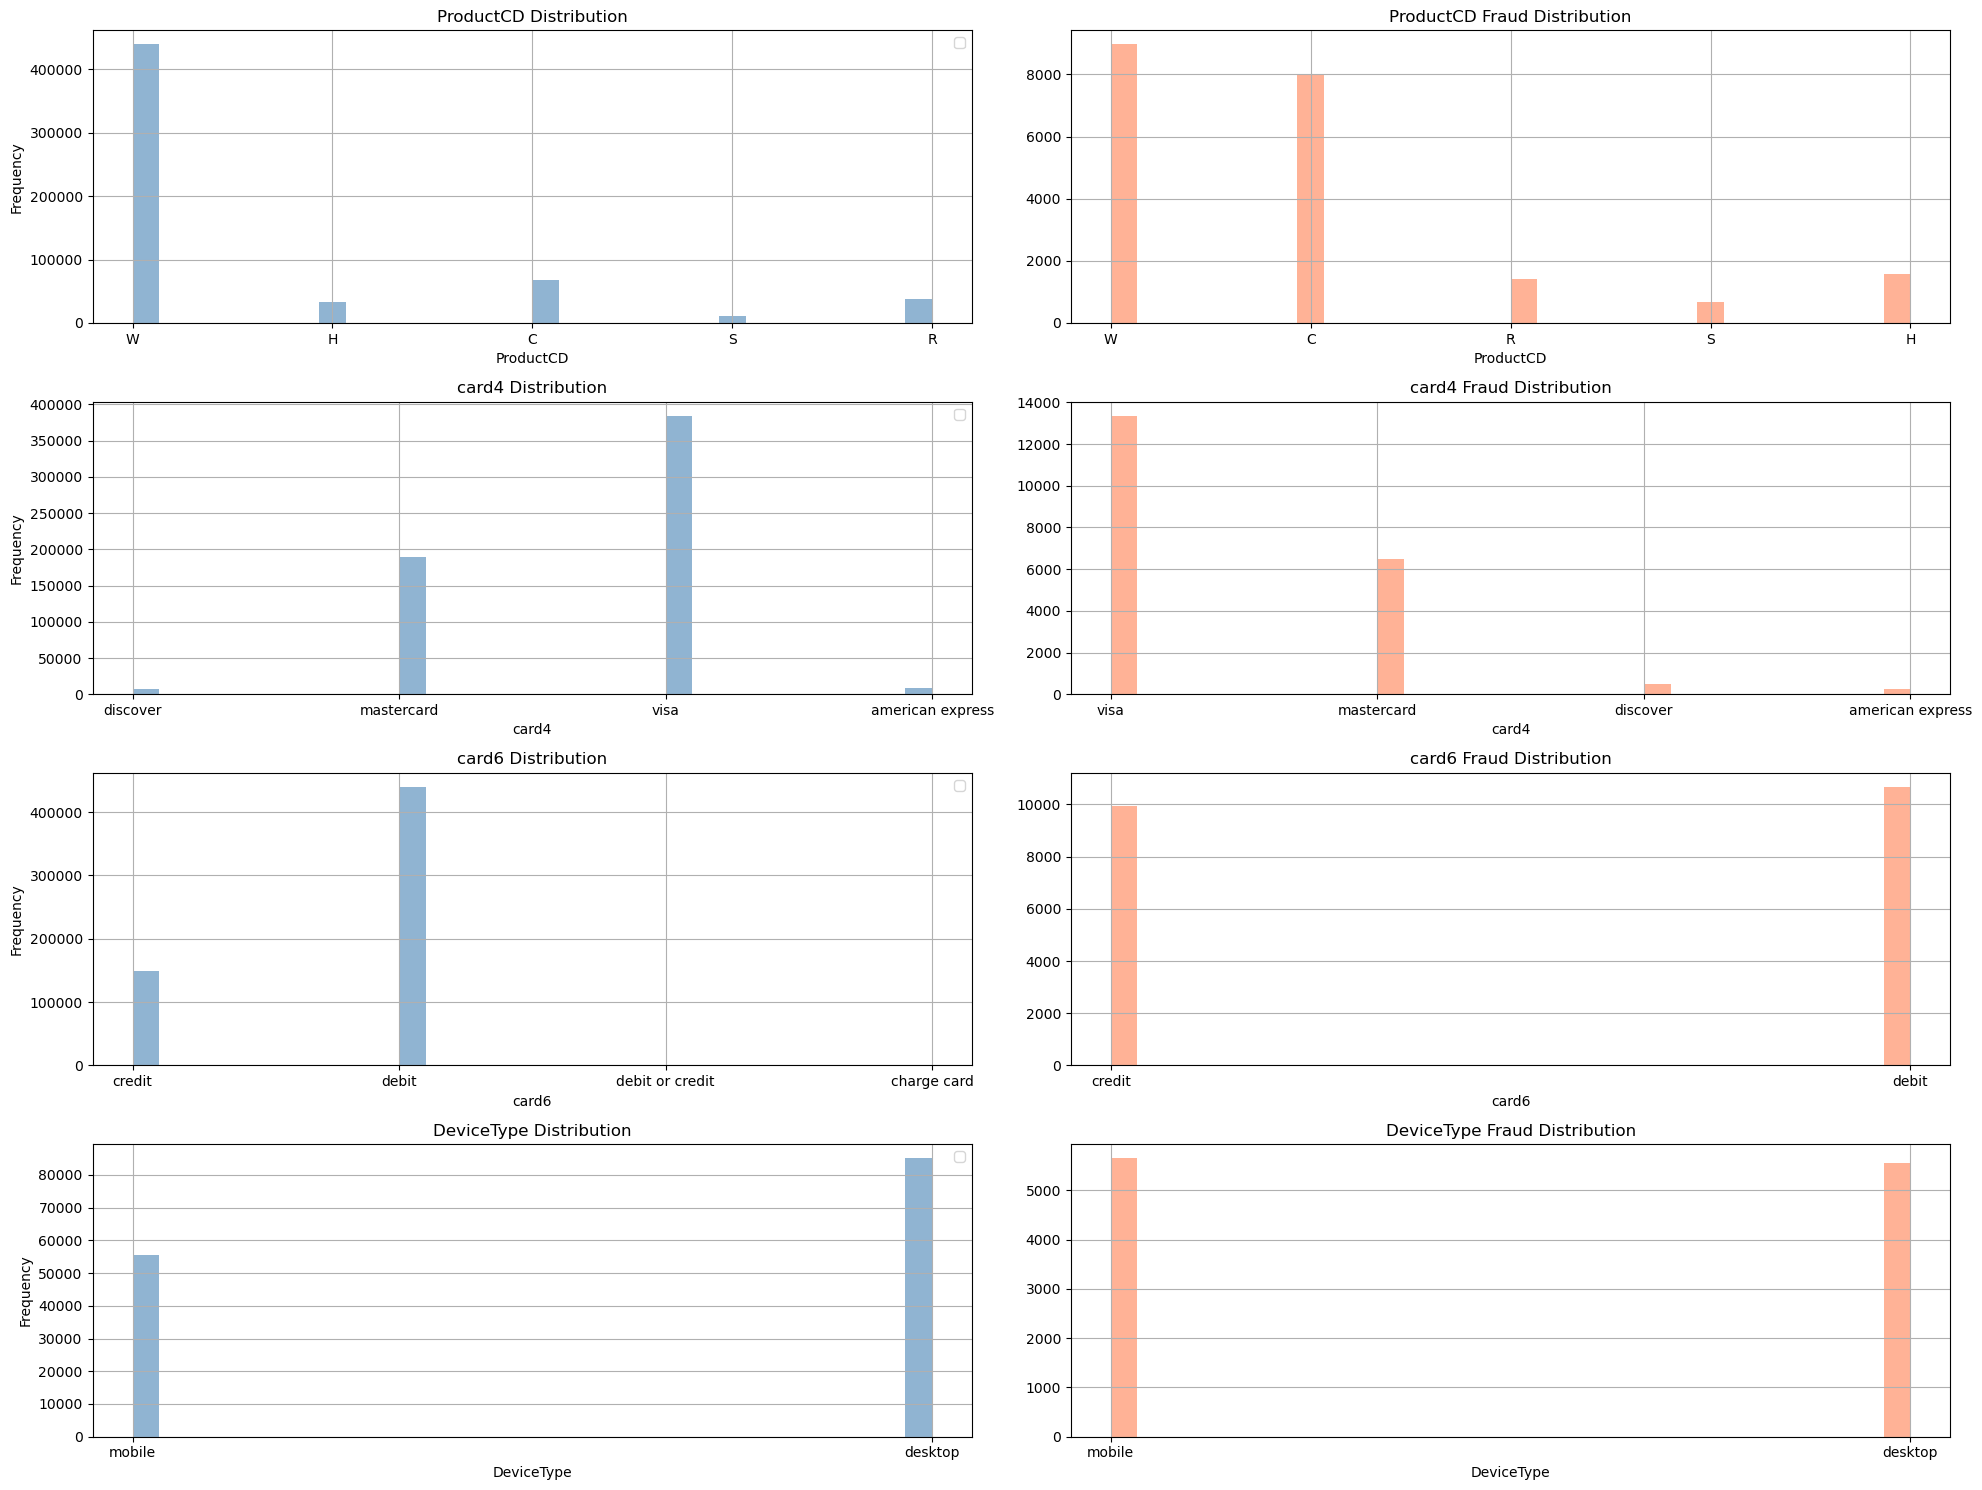

In [177]:
# Visualize key features by class
key_features = ['ProductCD', 'card4', 'card6', 'DeviceType']
fig, axes = plt.subplots(4, 2, figsize=(20, 15))
axes = axes.ravel()
n = 0

for idx, feature in enumerate(key_features):
    if idx > 0:
        idx = idx + n

    trans_train_clean[feature].hist(bins=30, alpha=0.6,   ax=axes[idx], color='steelblue')
 
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].set_title(f'{feature} Distribution')

    idx = idx + 1

    trans_train_clean[trans_train_clean['isFraud']==1][feature].hist(bins=30, alpha=0.6
                                                      , ax=axes[idx], color='coral')
    axes[idx].set_xlabel(feature)
    axes[idx].set_title(f'{feature} Fraud Distribution')

    n+=1



plt.tight_layout()
plt.show()

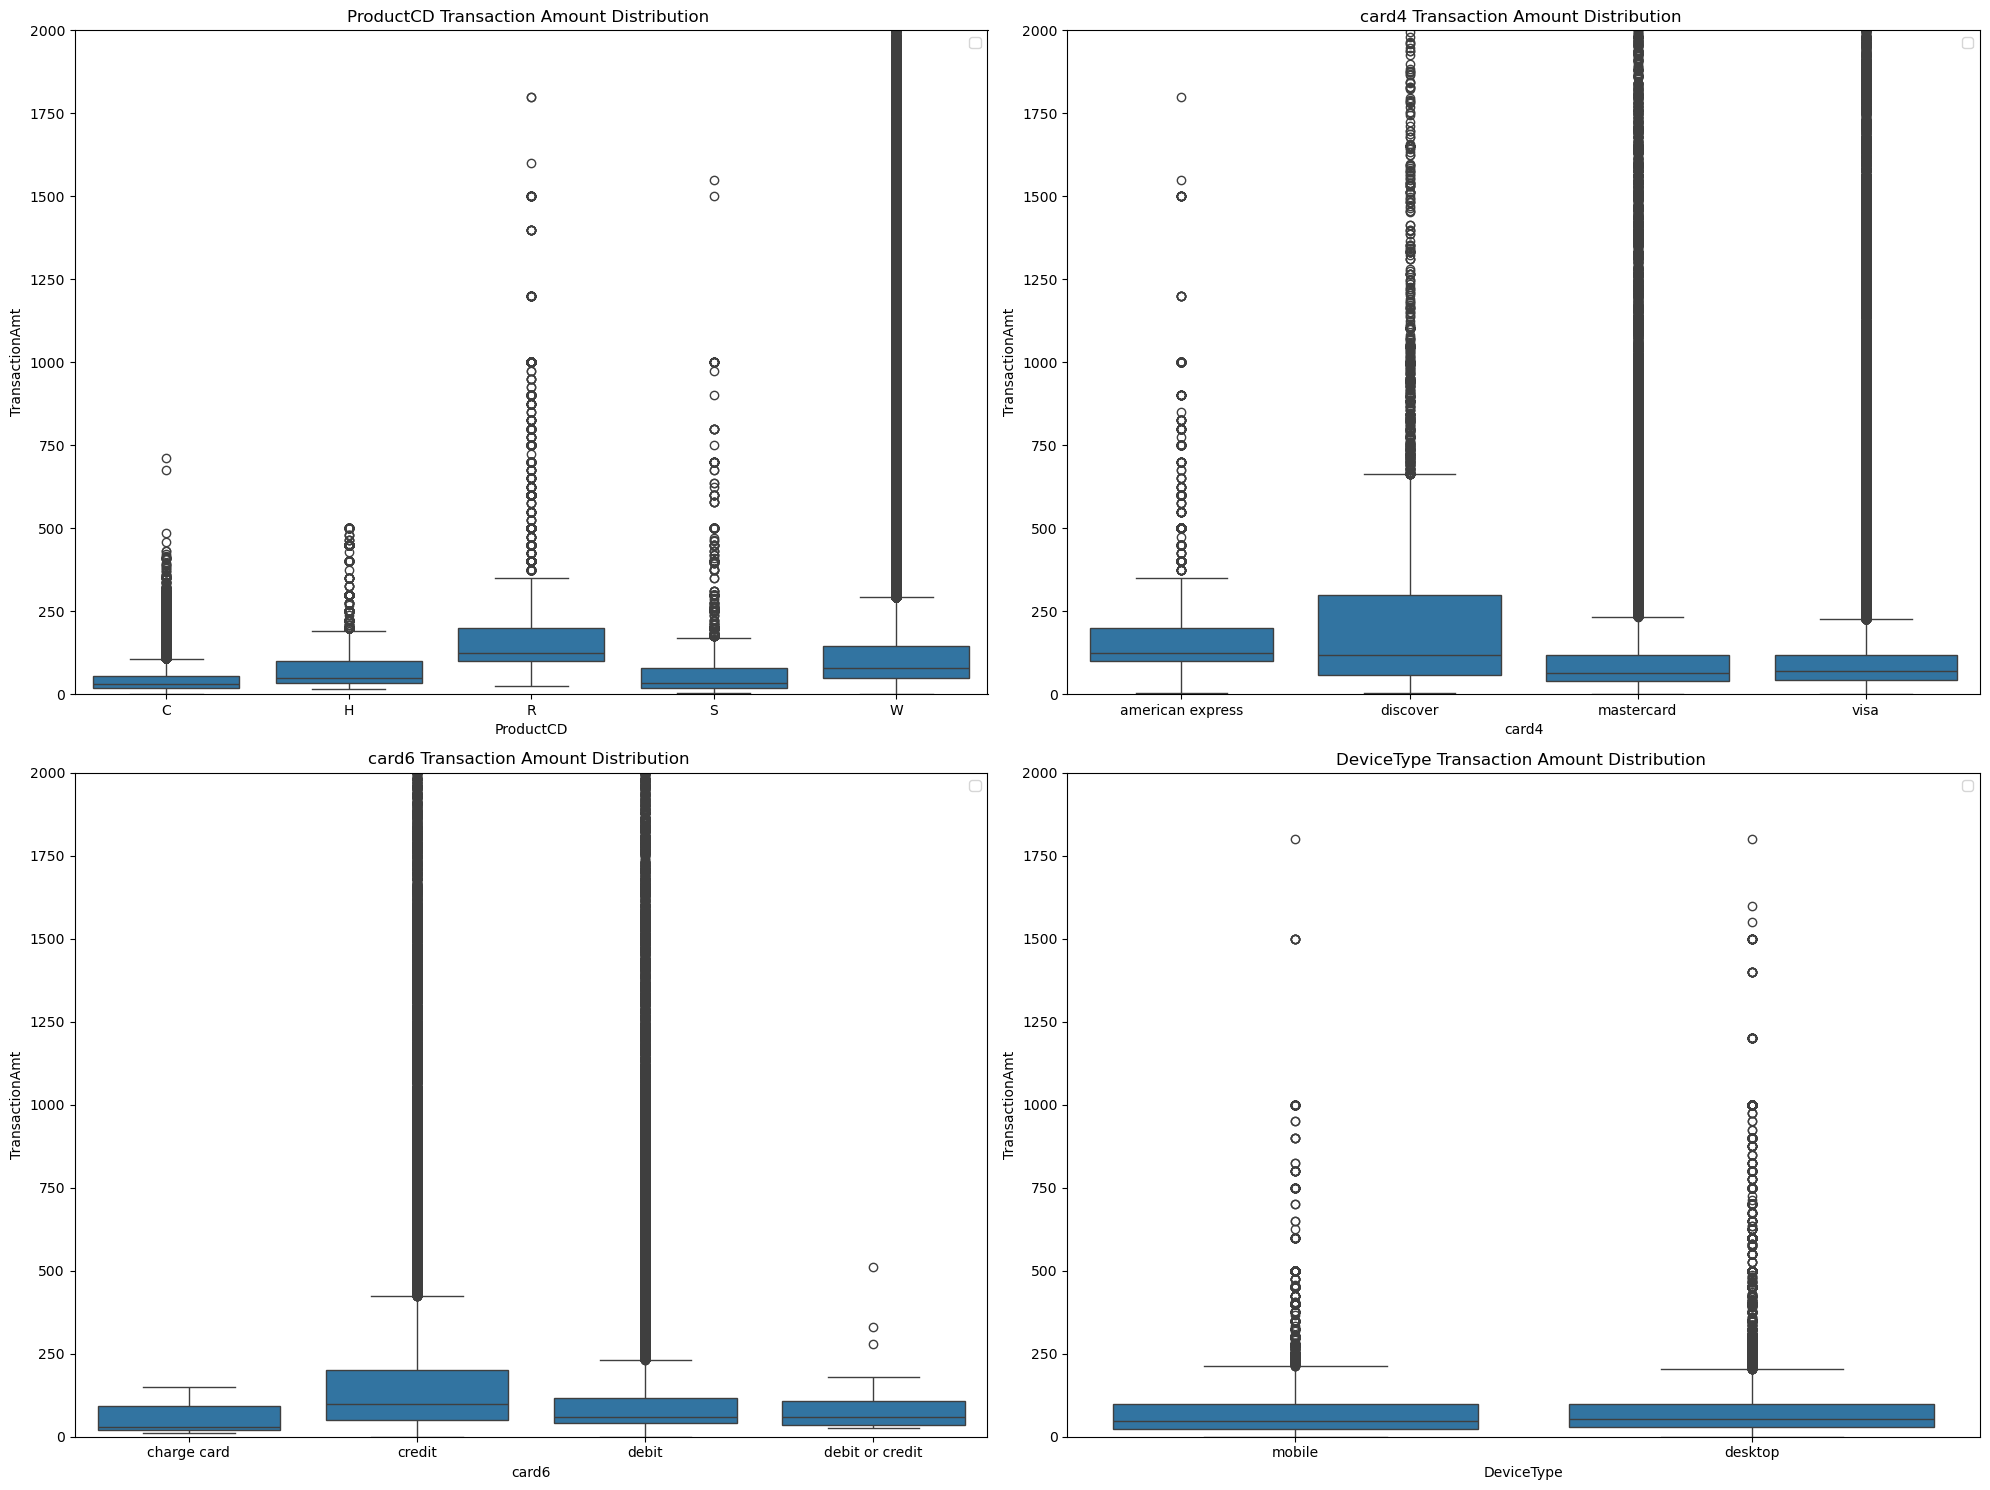

In [ ]:
# Visualize key features by class

key_features = ['ProductCD', 'card4', 'card6', 'DeviceType']
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.ravel()

for idx, feature in enumerate(key_features):

    sns.boxplot(data=trans_train_clean, x=feature,y= trans_train_clean["TransactionAmt"], ax=axes[idx])

    axes[idx].legend()
    axes[idx].set_title(f'{feature} Transaction Amount Distribution ')
    axes[idx].set_ylim(0, 2000) #Remove outliers


plt.tight_layout()
plt.show()

### 3.3 Feature Distributions

In [122]:
# Visualize distributions of key features
# Use histograms, box plots, etc.

### 3.4 Correlations

In [ ]:
# Correlation matrix

top_20_corr = trans_train_clean.corr(numeric_only=True)["isFraud"].abs().sort_values(ascending=False).head(11)


top_20_corr



isFraud    1.000000
V257       0.383060
V246       0.366878
V244       0.364129
V242       0.360590
V201       0.328005
V200       0.318783
V189       0.308219
V188       0.303582
V258       0.297151
V45        0.281832
V158       0.278066
V156       0.275952
V149       0.273282
V228       0.268861
V44        0.260376
V86        0.251828
V87        0.251737
V170       0.249794
V147       0.242894
V52        0.239469
Name: isFraud, dtype: float64

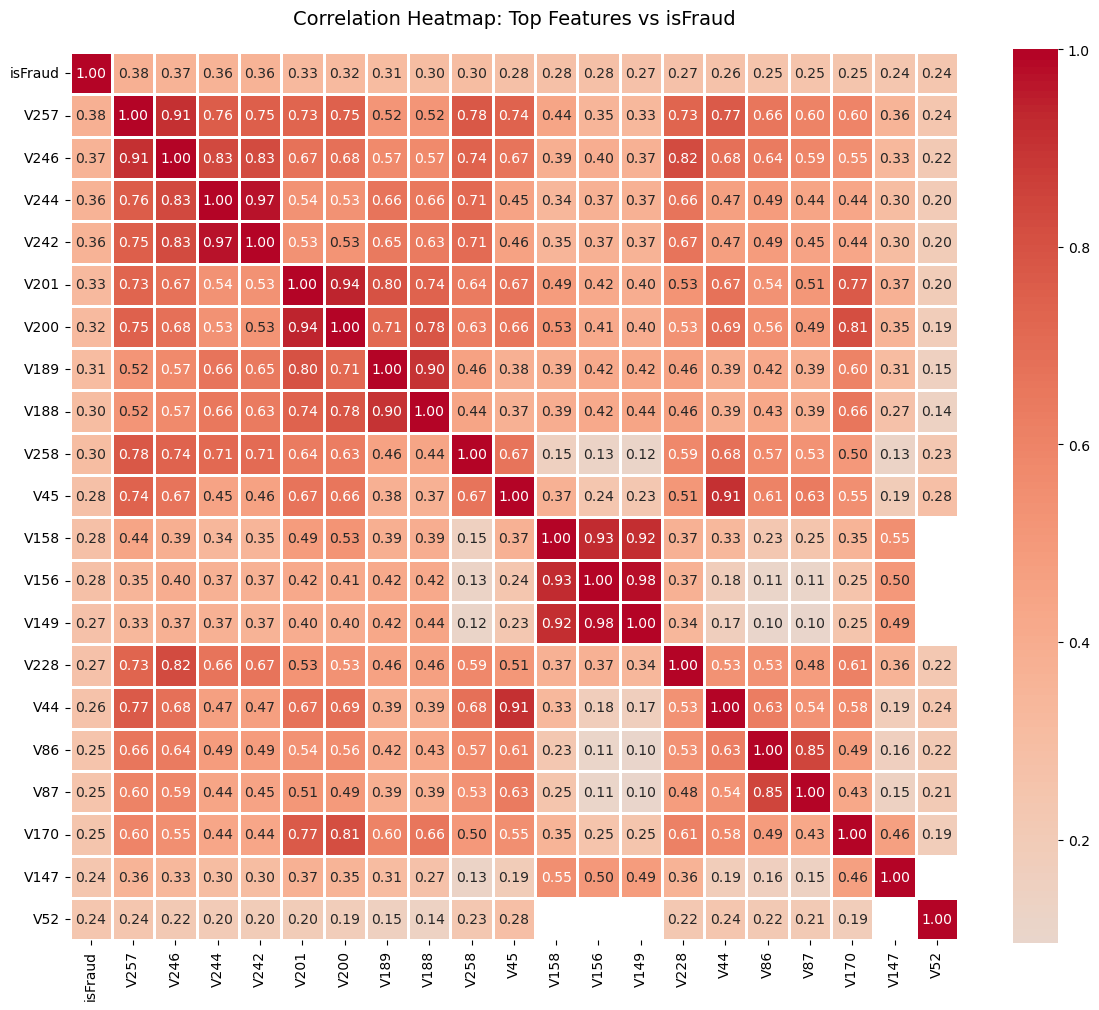

In [230]:
# Correlation heatmap
top_features = top_10_corr.index.tolist()


plt.figure(figsize=(12, 10))
sns.heatmap(trans_train_clean[top_features].corr(), annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1)
plt.title('Correlation Heatmap: Top Features vs isFraud', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

### 3.5 Key Insights from EDA

**Document your findings here:**
- Finding 1: [What you discovered]
- Finding 2: [What you discovered]
- Finding 3: [What you discovered]

---

## 4. Data Preprocessing

### 4.1 Handle Missing Values

In [124]:
# Handle missing values
# Options: drop, fill with mean/median, forward fill, etc.
# df_clean = df.dropna()
# OR
# df_clean = df.fillna(df.mean())

### 4.2 Handle Outliers

In [125]:
# Identify and handle outliers if necessary
# Use IQR method, z-score, or domain knowledge

### 4.3 Feature Engineering

In [126]:
# Create new features if beneficial
# Examples:
# - Combine existing features
# - Extract date components (year, month, day)
# - Create ratios or differences
# - Bin continuous variables

### 4.4 Encode Categorical Variables

In [127]:
# Encode categorical variables
# One-hot encoding for nominal categories
# Label encoding for ordinal categories

# categorical_cols = df_clean.select_dtypes(include=['object']).columns
# df_encoded = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

### 4.5 Prepare Features and Target

In [128]:
# Separate features and target
# X = df_encoded.drop('target_column', axis=1)
# y = df_encoded['target_column']

In [129]:
# Verify shapes
# X.shape, y.shape

---
## 5. Train-Test Split

In [130]:
# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

In [131]:
# Verify split
# f"Training: {X_train.shape[0]} samples | Testing: {X_test.shape[0]} samples"

---
## 6. Modeling

### 6.1 Baseline Model

In [132]:
# Start with a simple baseline model
# Example for classification:
# baseline_pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('model', LogisticRegression(random_state=42))
# ])

In [133]:
# Train baseline
# baseline_pipeline.fit(X_train, y_train)

In [134]:
# Evaluate baseline
# y_pred_baseline = baseline_pipeline.predict(X_test)
# baseline_score = accuracy_score(y_test, y_pred_baseline)
# f"Baseline Accuracy: {baseline_score:.1%}"

### 6.2 Model 2: [Your Second Model]

In [135]:
# Try a second model (e.g., Random Forest)
# model2 = Pipeline([
#     ('scaler', StandardScaler()),
#     ('model', RandomForestClassifier(random_state=42))
# ])

In [136]:
# Train
# model2.fit(X_train, y_train)

In [137]:
# Evaluate
# y_pred_2 = model2.predict(X_test)
# score_2 = accuracy_score(y_test, y_pred_2)
# f"Model 2 Accuracy: {score_2:.1%}"

### 6.3 Model 3: [Your Third Model]

In [138]:
# Try a third model
# Continue pattern from above

### 6.4 Compare Models

In [139]:
# Create comparison DataFrame
# results = pd.DataFrame({
#     'Model': ['Baseline', 'Model 2', 'Model 3'],
#     'Accuracy': [baseline_score, score_2, score_3],
#     'Precision': [...],
#     'Recall': [...],
#     'F1-Score': [...]
# })
# results

In [140]:
# Visualize comparison
# fig = px.bar(results, x='Model', y='Accuracy', 
#              title='Model Performance Comparison')
# fig.show()

---
## 7. Hyperparameter Tuning

### 7.1 Select Best Model for Tuning

In [141]:
# Based on comparison, select best model to tune
# best_model = model2  # Example

### 7.2 Define Parameter Grid

In [142]:
# Define parameters to search
# param_grid = {
#     'model__n_estimators': [50, 100, 200],
#     'model__max_depth': [5, 10, 20, None],
#     'model__min_samples_split': [2, 5, 10]
# }

### 7.3 Grid Search

In [143]:
# Perform grid search
# grid_search = GridSearchCV(
#     best_model,
#     param_grid,
#     cv=5,
#     scoring='accuracy',
#     n_jobs=-1
# )

# grid_search.fit(X_train, y_train)

In [144]:
# Best parameters
# grid_search.best_params_

In [145]:
# Best score
# grid_search.best_score_

### 7.4 Final Model

In [146]:
# Get best model
# final_model = grid_search.best_estimator_

---
## 8. Final Evaluation

### 8.1 Test Set Performance

In [147]:
# Predict on test set
# y_pred_final = final_model.predict(X_test)

In [148]:
# Calculate metrics
# For classification:
# final_accuracy = accuracy_score(y_test, y_pred_final)
# final_precision = precision_score(y_test, y_pred_final, average='weighted')
# final_recall = recall_score(y_test, y_pred_final, average='weighted')
# final_f1 = f1_score(y_test, y_pred_final, average='weighted')

# For regression:
# final_mse = mean_squared_error(y_test, y_pred_final)
# final_rmse = np.sqrt(final_mse)
# final_mae = mean_absolute_error(y_test, y_pred_final)
# final_r2 = r2_score(y_test, y_pred_final)

In [149]:
# Display metrics
# print(f"Final Model Performance:")
# print(f"Accuracy: {final_accuracy:.1%}")
# print(f"Precision: {final_precision:.1%}")
# print(f"Recall: {final_recall:.1%}")
# print(f"F1-Score: {final_f1:.1%}")

### 8.2 Classification Report

In [150]:
# Detailed classification report
# print(classification_report(y_test, y_pred_final))

### 8.3 Confusion Matrix

In [151]:
# For classification problems
# cm = confusion_matrix(y_test, y_pred_final)
# fig = px.imshow(cm, 
#                 text_auto=True,
#                 title='Confusion Matrix',
#                 labels=dict(x='Predicted', y='Actual'))
# fig.show()

### 8.4 Feature Importance

In [152]:
# If your model supports feature importance
# importances = final_model.named_steps['model'].feature_importances_
# feature_importance = pd.DataFrame({
#     'Feature': X.columns,
#     'Importance': importances
# }).sort_values('Importance', ascending=False)

# fig = px.bar(feature_importance.head(10), 
#              x='Importance', y='Feature',
#              title='Top 10 Most Important Features',
#              orientation='h')
# fig.show()

---
## 9. Business Insights & Recommendations

### 9.1 Key Findings

**Finding 1:** [Your insight]
- [Supporting detail]
- [Business implication]

**Finding 2:** [Your insight]
- [Supporting detail]
- [Business implication]

**Finding 3:** [Your insight]
- [Supporting detail]
- [Business implication]

### 9.2 Business Recommendations

1. **Recommendation 1:** [What should the business do?]
   - Expected impact: [Quantify if possible]
   
2. **Recommendation 2:** [What should the business do?]
   - Expected impact: [Quantify if possible]
   
3. **Recommendation 3:** [What should the business do?]
   - Expected impact: [Quantify if possible]

### 9.3 Model Limitations

- **Limitation 1:** [What doesn't the model handle well?]
- **Limitation 2:** [What assumptions were made?]
- **Limitation 3:** [What could go wrong?]

### 9.4 Future Improvements

- **Improvement 1:** [How could the model be enhanced?]
- **Improvement 2:** [What additional data would help?]
- **Improvement 3:** [What alternative approaches to try?]

---

## 10. Save Model

In [153]:
# Save final model
# joblib.dump(final_model, 'final_model.pkl')

In [154]:
# Save model metadata
# import json
# metadata = {
#     'model_type': 'RandomForestClassifier',
#     'accuracy': float(final_accuracy),
#     'features': X.columns.tolist(),
#     'training_date': '2024-12-XX',
#     'best_params': grid_search.best_params_
# }

# with open('model_metadata.json', 'w') as f:
#     json.dump(metadata, f, indent=2)

---
## 11. Conclusion

### Summary

**Problem:** [Restate the problem]

**Solution:** [Summarize your approach]

**Results:** [Key metrics and outcomes]

**Impact:** [Business value delivered]

### Next Steps

1. [What should happen next?]
2. [How should the model be deployed?]
3. [How should performance be monitored?]

---

**Thank you!**

---

**AI Tech Institute** | *Building Tomorrow's AI Engineers Today*